# Thesis Work - Nov 22 - MobileNetV2

## Importing Necessary Libraries

In [3]:
import os
import random
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

## Loading the Dataset's Kaggle Path

In [4]:
# Download latest version
path = kagglehub.dataset_download("wasifmahmood01/custom-waste-classification-dataset")

print("Path to Dataset Files:", path)

Using Colab cache for faster access to the 'custom-waste-classification-dataset' dataset.
Path to Dataset Files: /kaggle/input/custom-waste-classification-dataset


In [5]:
for root, dirs, files in os.walk(path):
    print(root)
    # Just show first few files in each directory
    for f in files[:5]:
        print("   ", f)
    print("------")

/kaggle/input/custom-waste-classification-dataset
------
/kaggle/input/custom-waste-classification-dataset/wastes
------
/kaggle/input/custom-waste-classification-dataset/wastes/test
------
/kaggle/input/custom-waste-classification-dataset/wastes/test/paper waste
    paper waste (241).jpg
    paper waste (296).jpg
    paper waste (18).jpg
    paper waste (322).jpg
    paper waste (264).jpg
------
/kaggle/input/custom-waste-classification-dataset/wastes/test/glass waste
    glass waste (161).jpg
    glass waste (208).jpg
    glass waste (18).jpg
    glass waste (197).jpg
    glass waste (23).jpg
------
/kaggle/input/custom-waste-classification-dataset/wastes/test/organic waste
    organic waste (27).png
    organic waste (70).png
    organic waste (1).jpeg
    organic waste (69).png
    organic waste (32).png
------
/kaggle/input/custom-waste-classification-dataset/wastes/test/plastic waste
    plastic waste (3).png
    plastic waste (111).jpg
    plastic waste (257).jpg
    plastic was

## Data Exploration & Preparation

In [6]:
# Update to your actual dataset path
data_dir = Path(path) / "wastes"
print("Using Data Directory:", data_dir)

Using Data Directory: /kaggle/input/custom-waste-classification-dataset/wastes


In [18]:
train_dir = data_dir / "train"
test_dir = data_dir / "test"

               Class  Image_Count
7        paper waste         1370
8      plastic waste         1315
0            E-waste         1248
5        metal waste         1231
3        glass waste         1022
6      organic waste          889
1  automobile wastes          871
2      battery waste          848
4        light bulbs          420


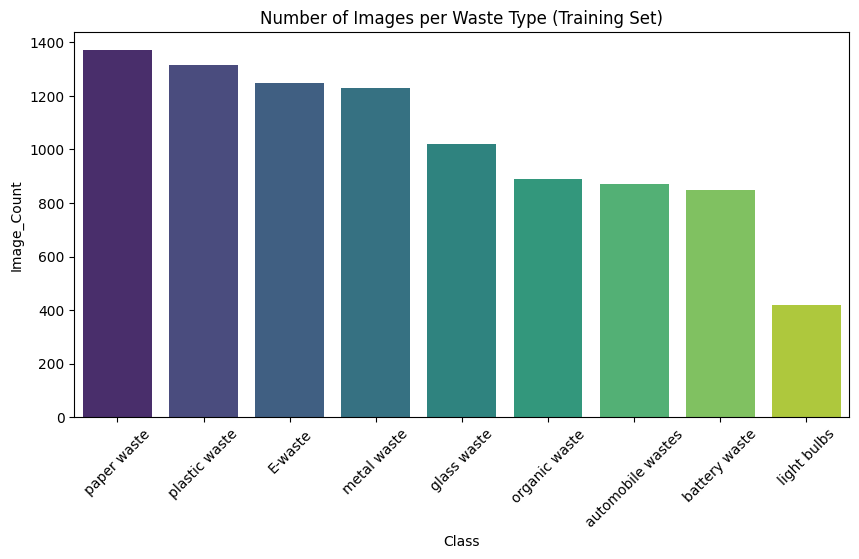

In [19]:
# Count the number of images in each class (from train directory)
classes = sorted(os.listdir(train_dir))
counts = {cls: len(os.listdir(train_dir / cls)) for cls in classes}

df_counts = pd.DataFrame(list(counts.items()), columns = ['Class', 'Image_Count']) \
               .sort_values(by = 'Image_Count', ascending = False)

print(df_counts)

plt.figure(figsize = (10,5))
sns.barplot(data = df_counts, x = 'Class', y = 'Image_Count', hue = 'Class', palette = 'viridis', legend = False)
plt.title("Number of Images per Waste Type (Training Set)")
plt.xticks(rotation = 45)
plt.show()

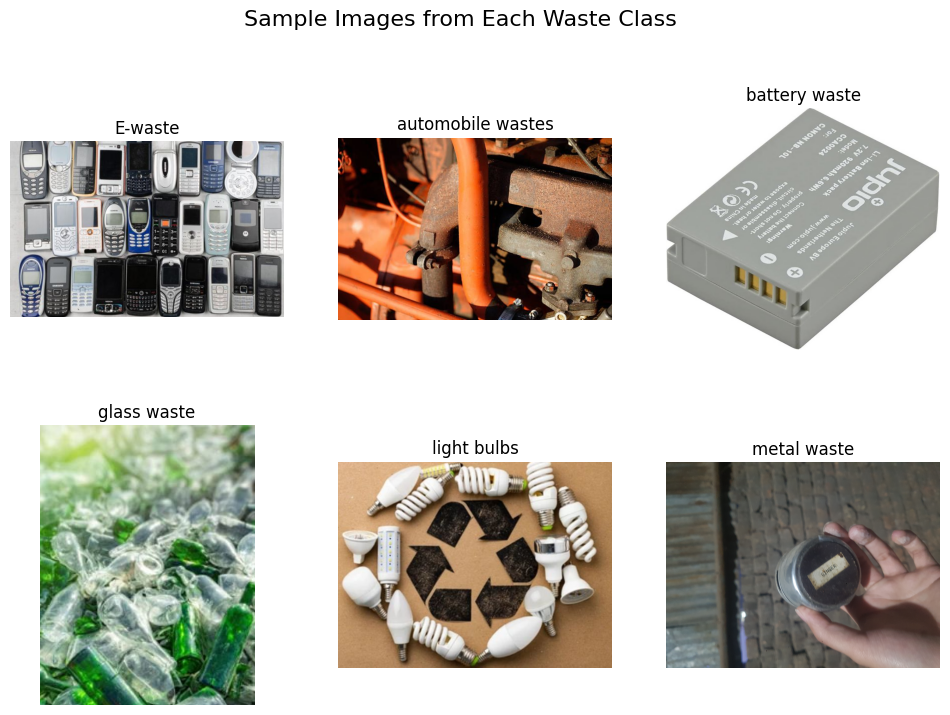

In [20]:
# Preview sample images from each waste class
fig, axes = plt.subplots(2, 3, figsize = (12,8))

for ax, cls in zip(axes.flatten(), classes):
    img_path = train_dir / cls / random.choice(os.listdir(train_dir / cls))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

plt.suptitle("Sample Images from Each Waste Class", fontsize=16)
plt.show()

In [21]:
# Are there any corrupted images? (scanning the training set)
corrupted = []

for cls in classes:
    folder = train_dir / cls
    for file in os.listdir(folder):
        path_img = folder / file
        try:
            img = Image.open(path_img)
            img.verify()
        except:
            corrupted.append(str(path_img))

print(f"{len(corrupted)} corrupted images found.")
if corrupted:
    print("Example:", corrupted[:3])

0 corrupted images found.


Scanning plastic waste: 100%|██████████| 1315/1315 [00:00<00:00, 1525.11it/s]


             Width       Height
count  9214.000000  9214.000000
mean    949.699045   800.735620
std    1145.343332  1017.750853
min      52.000000    40.000000
25%     408.000000   324.000000
50%     586.000000   408.000000
75%     622.000000   612.000000
max    6898.000000  7262.000000


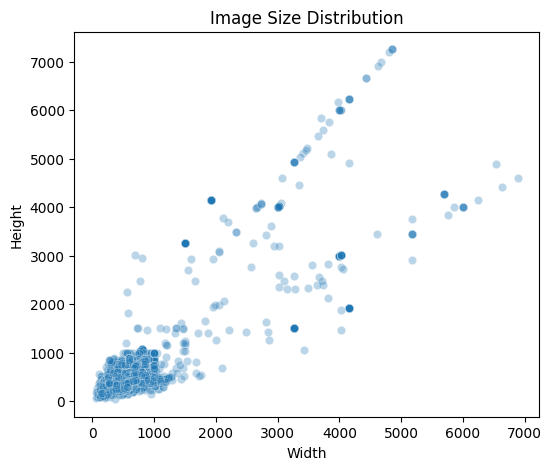

In [22]:
dims = []

for cls in classes:
    folder = train_dir / cls
    for file in tqdm(os.listdir(folder), desc = f"Scanning {cls}"):
        path_img = folder / file
        try:
            with Image.open(path_img) as img:
                dims.append(img.size)
        except:
            pass  # catch corrupted images

df_dims = pd.DataFrame(dims, columns = ['Width', 'Height'])
print(df_dims.describe())

plt.figure(figsize = (6,5))
sns.scatterplot(data = df_dims, x = 'Width', y = 'Height', alpha = 0.3)
plt.title("Image Size Distribution")
plt.show()

## Adding Generators

In [28]:
img_size = (224, 224) # Will define a new image size variable equal to (300, 300) for the B3 model
batch_size = 32

# Training DataGenerator with a validation split (because we don't have a validation folder)
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2
)

# Test/Val DataGenerator (no augmentation)
val_test_datagen = ImageDataGenerator(rescale = 1./255)

# Training generator (80% of train)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"
)

# Validation Generator (20% of train)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    shuffle = False
)

# Testing Generator (An independent folder)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False
)

print("Class Indices:", train_generator.class_indices)

Found 7374 images belonging to 9 classes.
Found 1840 images belonging to 9 classes.
Found 2308 images belonging to 9 classes.
Class Indices: {'E-waste': 0, 'automobile wastes': 1, 'battery waste': 2, 'glass waste': 3, 'light bulbs': 4, 'metal waste': 5, 'organic waste': 6, 'paper waste': 7, 'plastic waste': 8}


In [29]:
# Compute class weights to handle class imbalance
y_classes = train_generator.classes

class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(y_classes),
    y = y_classes
)

class_weights = dict(enumerate(class_weights))

print("\nClass Weights:")
print(class_weights)


Class Weights:
{0: np.float64(0.8201534868201534), 1: np.float64(1.1755141080822573), 2: np.float64(1.2066764850270004), 3: np.float64(1.0016299918500406), 4: np.float64(2.4384920634920637), 5: np.float64(0.8318104906937395), 6: np.float64(1.150749063670412), 7: np.float64(0.7475669099756691), 8: np.float64(0.7788339670468948)}


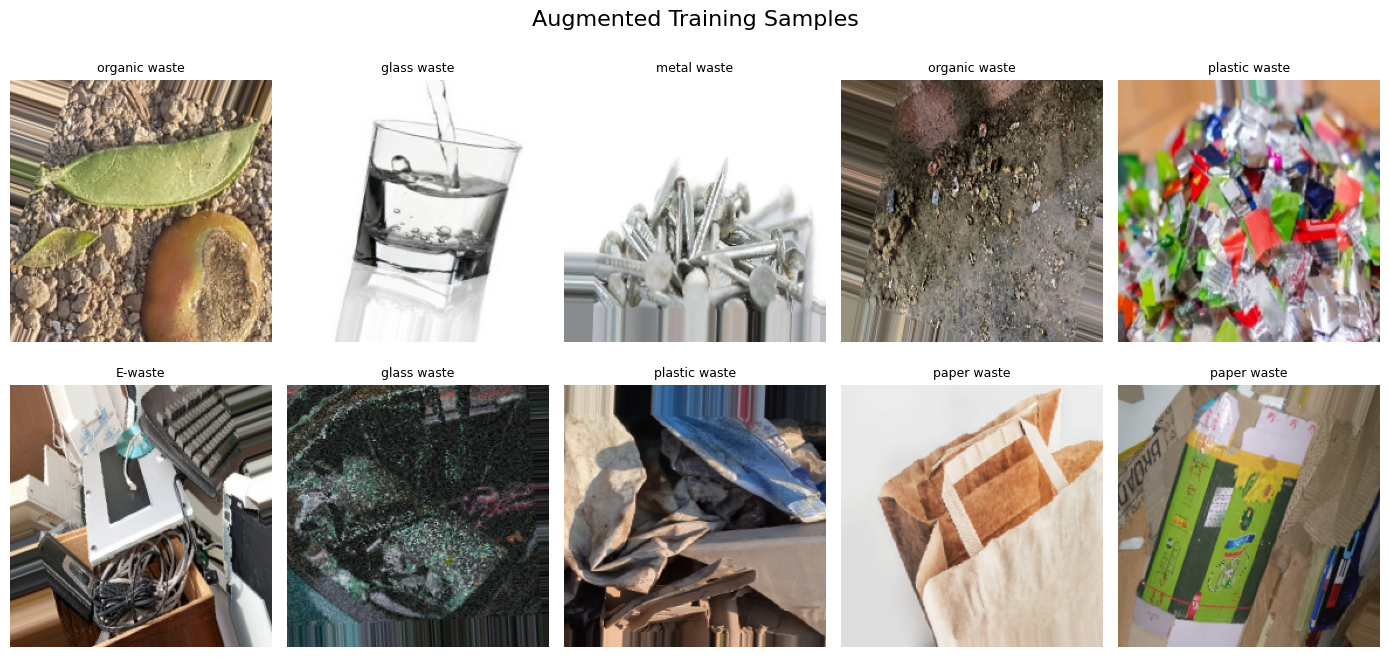

In [30]:
# Visualize Augmented Samples
x_batch, y_batch = next(train_generator)
labels_map = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(14, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_batch[i])
    cls_idx = np.argmax(y_batch[i])
    plt.title(labels_map[cls_idx], fontsize=9)
    plt.axis("off")

plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()

## Model Building #1 (MobileNetV2)

In [31]:
base_model = MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = False  # freeze feature extractor

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(train_generator.num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = preds)

model.compile(
    optimizer = Adam(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

In [32]:
# Train frozen model for 10 epochs with class weights
history_frozen = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
    class_weight = class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 659s 3s/step - accuracy: 0.1476 - loss: 2.5726 - val_accuracy: 0.3272 - val_loss: 1.8794
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.3565 - loss: 1.8071 - val_accuracy: 0.4679 - val_loss: 1.5569
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - accuracy: 0.4925 - loss: 1.4415 - val_accuracy: 0.5304 - val_loss: 1.3828
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.5542 - loss: 1.2793 - val_accuracy: 0.5527 - val_loss: 1.2931
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 654s 3s/step - accuracy: 0.5974 - loss: 1.1633 - val_accuracy: 0.5788 - val_loss: 1.2371
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 686s 3s/step - accuracy: 0.6136 - loss: 1.1005 - val_accuracy: 0.5815 - val_loss: 1.1977
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 653s 3s/step - accuracy: 0.6386 - loss: 1.0335 - val_accuracy: 0.6022 - val_loss: 1.1686
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 649s 3s/step - accuracy: 0.6505 - loss: 0.9769 - val_accu

In [51]:
mobile_final_train_acc = max(history_frozen.history['accuracy'])
mobile_final_val_acc   = max(history_frozen.history['val_accuracy'])

print(f"Highest Training Accuracy (MobileNetV2 Frozen Model):   {mobile_final_train_acc * 100:.2f}%")
print()
print(f"Highest Validation Accuracy (MobileNetV2 Frozen Model): {mobile_final_val_acc * 100:.2f}%")

Highest Training Accuracy (MobileNetV2 Frozen Model):   66.94%

Highest Validation Accuracy (MobileNetV2 Frozen Model): 62.50%


## Model Evaluation

In [34]:
# Choose evaluation generator
eval_gen = test_generator if test_generator else val_generator

# Number of steps
steps = int(np.ceil(eval_gen.samples / eval_gen.batch_size))

# Make predictions
preds = model.predict(eval_gen, steps = steps, verbose = 1)
y_pred = np.argmax(preds, axis = 1)
y_true = eval_gen.classes

# Class labels
labels = [k for k, v in sorted(eval_gen.class_indices.items(), key=lambda x: x[1])]

# Classification Report
print()
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step

Classification Report:
                   precision    recall  f1-score   support

          E-waste       0.75      0.65      0.70       313
automobile wastes       0.66      0.83      0.73       218
    battery waste       0.66      0.65      0.66       213
      glass waste       0.66      0.60      0.63       256
      light bulbs       0.65      0.71      0.68       105
      metal waste       0.52      0.66      0.58       308
    organic waste       0.74      0.87      0.80       223
      paper waste       0.76      0.72      0.74       343
    plastic waste       0.74      0.53      0.62       329

         accuracy                           0.68      2308
        macro avg       0.68      0.69      0.68      2308
     weighted avg       0.69      0.68      0.68      2308



In [35]:
# Macro F1 Score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

Macro F1 Score: 0.6820


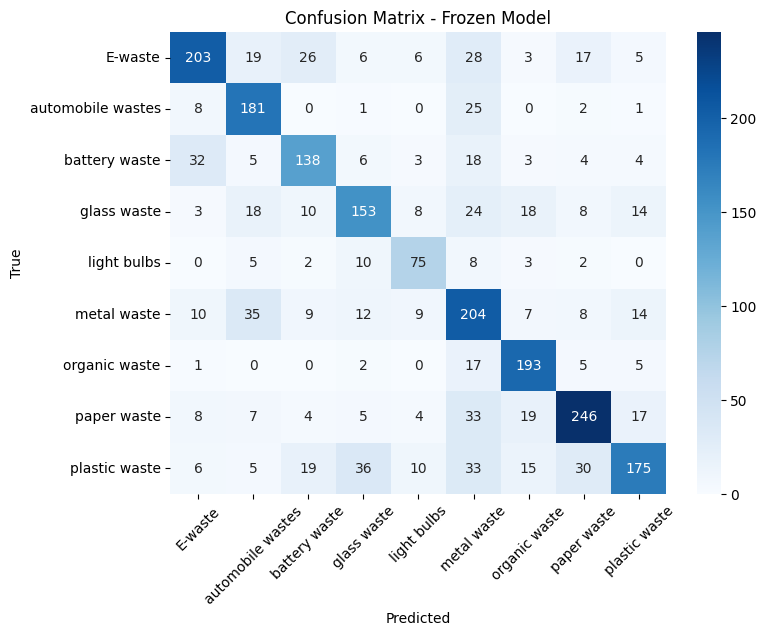

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Frozen Model")
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.show()

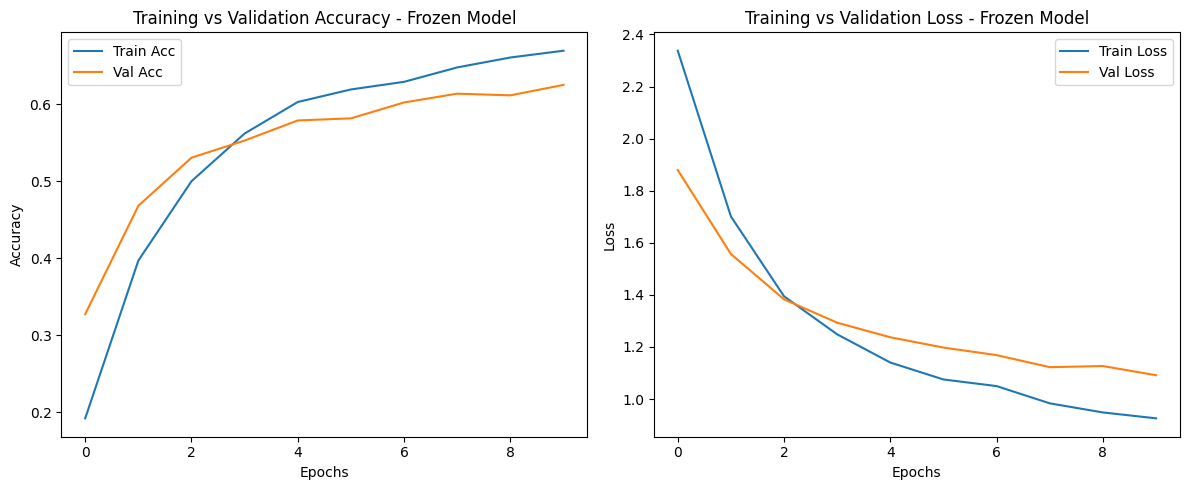

In [38]:
plt.figure(figsize = (12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history_frozen.history['accuracy'], label='Train Acc')
plt.plot(history_frozen.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy - Frozen Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history_frozen.history['loss'], label='Train Loss')
plt.plot(history_frozen.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss - Frozen Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display both plots
plt.tight_layout()
plt.show()

## Fine-Tuning + Another Round of Model Training & Evaluation (MobileNetV2)

In [39]:
# Unfreeze last layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [40]:
# Re-compile with a lower learning rate (LR)
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [41]:
# Train again for additional epochs
history_finetune = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10
)

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 805s 3s/step - accuracy: 0.5674 - loss: 1.2589 - val_accuracy: 0.6277 - val_loss: 1.0880
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step - accuracy: 0.6572 - loss: 0.9890 - val_accuracy: 0.6397 - val_loss: 1.0555
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.7007 - loss: 0.8865 - val_accuracy: 0.6636 - val_loss: 1.0148
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 735s 3s/step - accuracy: 0.7114 - loss: 0.8542 - val_accuracy: 0.6620 - val_loss: 0.9964
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 860s 4s/step - accuracy: 0.7409 - loss: 0.7770 - val_accuracy: 0.6783 - val_loss: 0.9516
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 734s 3s/step - accuracy: 0.7451 - loss: 0.7467 - val_accuracy: 0.6913 - val_loss: 0.9380
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - accuracy: 0.7536 - loss: 0.7229 - val_accuracy: 0.6957 - val_loss: 0.9024
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 738s 3s/step - accuracy: 0.7723 - loss: 0.6638 - val_accu

In [50]:
# Print accuracies of the fine-tuned MobileNetV2 model
mobile_fine_tuned_final_train_acc = max(history_finetune.history['accuracy'])
mobile_fine_tuned_final_val_acc = max(history_finetune.history['val_accuracy'])

print(f"Highest Training Accuracy (Fine-Tuned MobileNetV2 Model):   {mobile_fine_tuned_final_train_acc * 100:.2f}%")
print()
print(f"Highest Validation Accuracy (Fine-Tuned MobileNetV2 Model): {mobile_fine_tuned_final_val_acc * 100:.2f}%")

Highest Training Accuracy (Fine-Tuned MobileNetV2 Model):   78.55%

Highest Validation Accuracy (Fine-Tuned MobileNetV2 Model): 71.36%


In [43]:
# Evaluate the fine-tuned MobileNetV2 model
eval_gen = test_generator

steps = int(np.ceil(eval_gen.samples / eval_gen.batch_size))
preds = model.predict(eval_gen, steps = steps, verbose = 1)

y_pred = np.argmax(preds, axis = 1)
y_true = eval_gen.classes
labels = [k for k,v in sorted(eval_gen.class_indices.items(), key = lambda x:x[1])]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names = labels, zero_division = 0))

73/73 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step
Classification Report:
                   precision    recall  f1-score   support

          E-waste       0.76      0.77      0.76       313
automobile wastes       0.75      0.85      0.79       218
    battery waste       0.88      0.70      0.78       213
      glass waste       0.78      0.68      0.73       256
      light bulbs       0.85      0.75      0.80       105
      metal waste       0.65      0.78      0.71       308
    organic waste       0.90      0.88      0.89       223
      paper waste       0.81      0.86      0.83       343
    plastic waste       0.77      0.71      0.74       329

         accuracy                           0.78      2308
        macro avg       0.79      0.78      0.78      2308
     weighted avg       0.78      0.78      0.78      2308



In [44]:
macro_f1 = f1_score(y_true, y_pred, average = 'macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

Macro F1 Score: 0.7809


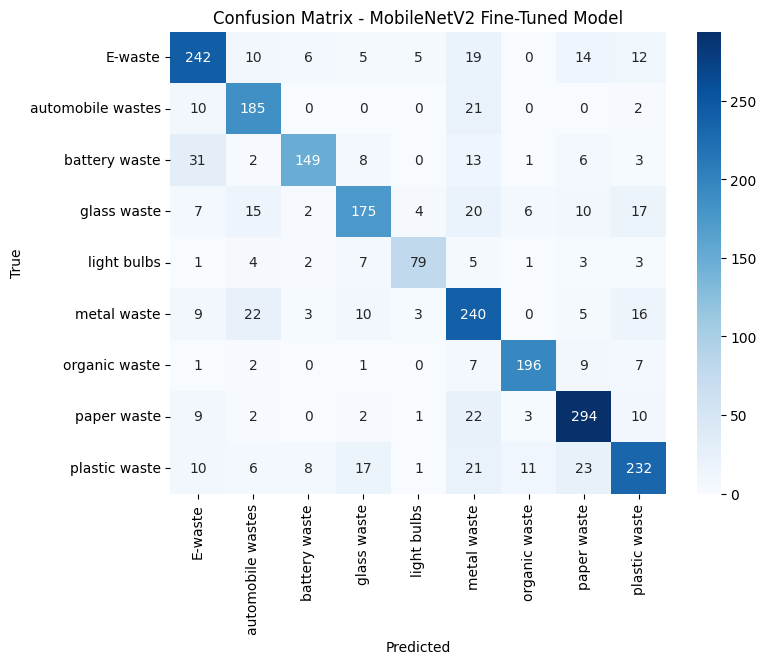

In [45]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MobileNetV2 Fine-Tuned Model")
plt.show()

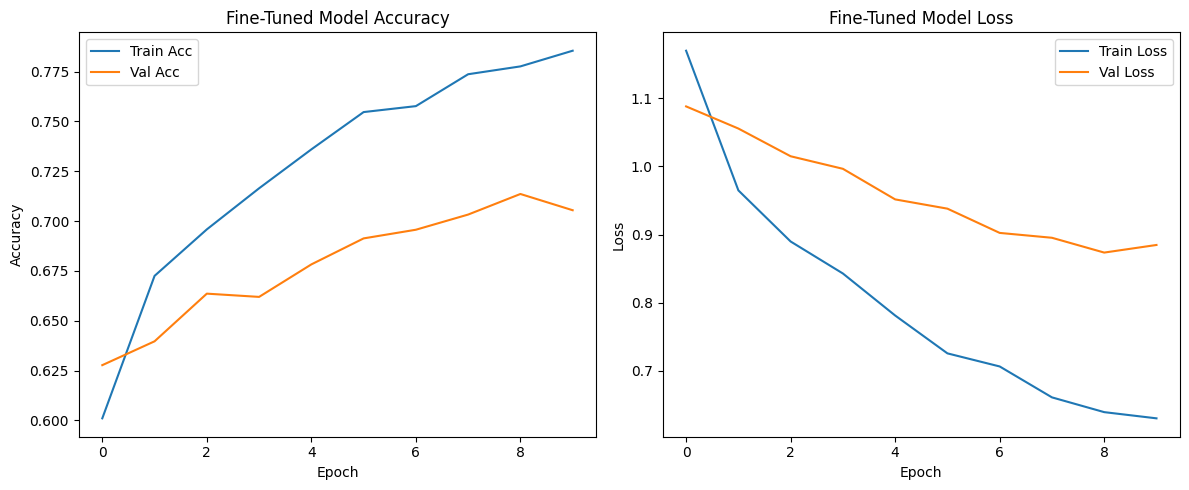

In [46]:
plt.figure(figsize = (12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label = 'Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label = 'Val Acc')
plt.legend()
plt.title('Fine-Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label = 'Train Loss')
plt.plot(history_finetune.history['val_loss'], label = 'Val Loss')
plt.legend()
plt.title('Fine-Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display both plots
plt.tight_layout()
plt.show()